# Trader centrality calculation

Two seperate directed graphs for traders are built for each unique date found in the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm

Original data

In [ ]:
nft_transactions = pd.read_csv('data/training/Data_API.csv',usecols=['Seller_address','Buyer_address','Datetime_updated','Datetime_updated_seconds','Unique_id_collection','Collection_cleaned','Category'])

In [ ]:
nft_transactions.Datetime_updated = pd.to_datetime(nft_transactions.Datetime_updated)
nft_transactions.Datetime_updated_seconds = pd.to_datetime(nft_transactions.Datetime_updated_seconds)

In [ ]:
unique_dates = list(nft_transactions.groupby('Datetime_updated').groups.keys())

## Create networks and calculate centrality

In [ ]:
G_seller = nx.DiGraph()
G_buyer = nx.DiGraph()
dataframes = []
for i, date in tqdm(enumerate(unique_dates), total=len(unique_dates)):
  # filter transactions to only include transactions between current and previous date
  prev_date = unique_dates[i-1] if i > 0 else unique_dates[0]
  date_mask = (nft_transactions.Datetime_updated >= prev_date) & (nft_transactions.Datetime_updated < date)
  date_transactions = nft_transactions.loc[date_mask]
  # add transactions as edges to the networks
  for index, row in date_transactions.iterrows():
    # add prefix '_' to nft ids to filter them later on (none of the addresses start with '_')
    G_seller.add_edges_from([(row.Seller_address, f'_{row.Unique_id_collection}')])
    G_buyer.add_edges_from([(row.Buyer_address, f'_{row.Unique_id_collection}')])
  # calculate centrality of nodes so far
  centrality_seller = nx.degree_centrality(G_seller)
  centrality_buyer = nx.degree_centrality(G_buyer)
  # filter to address nodes
  centrality_seller_address_nodes = {key:value for key, value in centrality_seller.items() if '_' not in key}.items()
  centrality_buyer_address_nodes = {key:value for key, value in centrality_buyer.items() if '_' not in key}.items()
  # convert dict items to pandas dataframe
  centrality_seller_address = pd.DataFrame(centrality_seller_address_nodes, columns=['Seller_address','centrality_seller'])
  centrality_buyer_address = pd.DataFrame(centrality_buyer_address_nodes, columns=['Buyer_address','centrality_buyer'])
  # merge with this dates nft transaction data
  merged_with_seller_and_buyer = (nft_transactions.loc[nft_transactions.Datetime_updated == date]
    .merge(centrality_seller_address, on='Seller_address', how='left')
    .merge(centrality_buyer_address, on='Buyer_address', how='left'))
  dataframes.append(merged_with_seller_and_buyer)
nft_transactions_with_centrality = pd.concat(dataframes)
nft_transactions_with_centrality

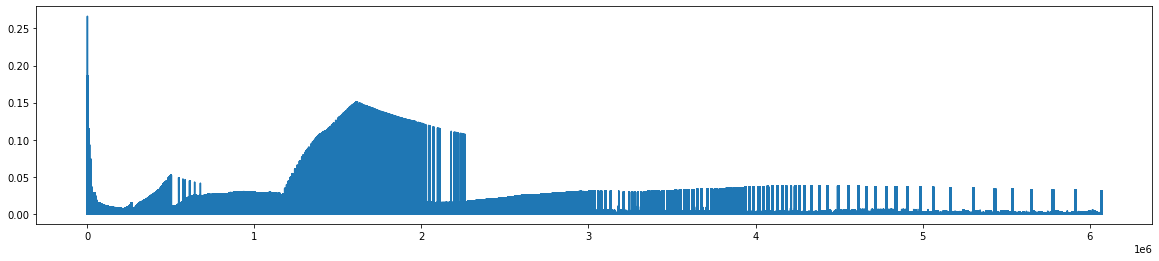

In [ ]:
nft_transactions_with_centrality.reset_index().centrality_seller.plot(figsize=(20,4))

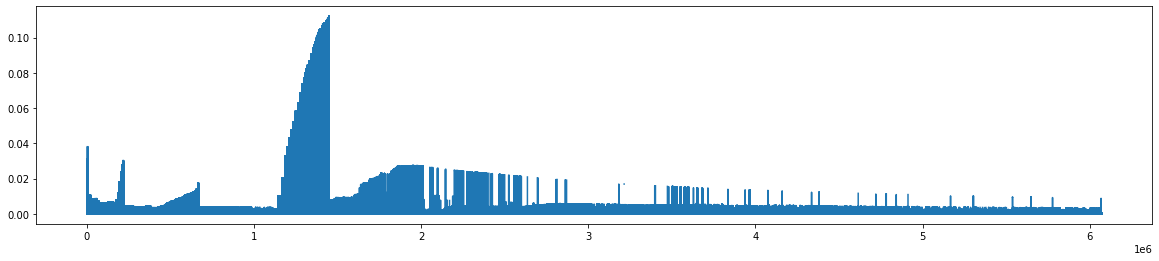

In [ ]:
nft_transactions_with_centrality.reset_index().centrality_buyer.plot(figsize=(20,4))